# Classification Experiments 
By: Shateesh Bhugwansing


### Experiment 1 - Logistic Regression

__Data__: EpochedEEG/20131216_1441_epo.fif (Epoched data from Emmanuil's batch script)

__Problem__: Classify target vs. flanker stimuli 

__Procedure__:
1. perform PCA on data to reduce the number of channels 129 to 9
2. reassign event_id's for each epoch. target = 140, flanker = 160
3. Run logistic regression classifier on the original data
4. Run the same classifier in step 3, on the PCA data and compare results. 
    

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (50.0, 30.0)
matplotlib.rcParams.update({'font.size': 15})

In [2]:
path = '/Volumes/SB/EpochedEEG/20131216_1441_epo.fif'
epoch = mne.read_epochs(path, preload=True)


Reading /Volumes/SB/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [3]:
from mne.datasets import sample
from mne.decoding import UnsupervisedSpatialFilter

from sklearn.decomposition import PCA

In [ ]:
pca = UnsupervisedSpatialFilter(PCA(9), average=False) # PCA, keep 9 components 

epoch_data = epoch.get_data()
pca_data = pca.fit_transform(epoch_data)

In [ ]:
import pickle

pickle.dump(pca_data, open('pca_data_20131216_1441.pkl', 'wb'))
pickle.dump(epoch_data, open('epoch_data_20131216_1441.pkl', 'wb'))

In [4]:
filtered_epoch = epoch[(epoch.events[:,-1] >= 135) & (epoch.events[:,-1] <= 165)]

In [ ]:
pickle.dump(filtered_epoch, open('filtered_epoch_20131216_1441.pkl', 'wb'))

In [5]:
filtered_epoch_data = filtered_epoch.get_data()
filtered_epoch_data.shape

(1280, 129, 180)

In [ ]:
filtered_pca_data = pca.fit_transform(filtered_epoch_data)
filtered_pca_data.shape

In [ ]:
pickle.dump(filtered_epoch_data, open('filtered_epoch_data_20131216_1441.pkl', 'wb'))
pickle.dump(filtered_pca_data, open('filtered_pca_data_20131216_1441.pkl', 'wb'))

In [6]:
# change the event id to '140' for target, and '160' for flanker. 

for x in filtered_epoch.events:
    if x[-1] <= 145:
        x[-1] = 140
    else:
        x[-1] = 160

In [7]:
filtered_epoch.events

array([[  2581,     31,    140],
       [  2583,      0,    160],
       [  3671,      0,    140],
       ...,
       [658086,      0,    160],
       [658618,     31,    140],
       [658620,      0,    160]])

### Logistic Regression on epoched data (129 Channels) 

In [14]:
from mne.decoding import Vectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa

from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout

In [ ]:
# use logistic regression, L1 penalty 


from mne.preprocessing import Xdawn


clf = make_pipeline(
                    Vectorizer(),
                    MinMaxScaler(),
                    LogisticRegression(penalty='l1'))

# logReg = LogisticRegression()

#cross validator
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)


#Do cross-validation
labels = filtered_epoch.events[:,-1]
preds = np.empty(len(filtered_epoch._data))
for train, test in cv.split(filtered_epoch._data, labels):
    clf.fit(filtered_epoch._data[train], labels[train])
    preds[test] = clf.predict(filtered_epoch.get_data()[test])
    
target_names = [ '140', '160']
report = classification_report(labels, preds, target_names=target_names)
print(report)

In [ ]:
# Normalized confusion matrix
from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout



cm = confusion_matrix(labels, preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix -- Logistic Regression')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Experiment 2 - SVM

__Data__: EpochedEEG/20131216_1441_epo.fif (Epoched data from Emmanuil's batch script)

__Problem__: Classify target vs. flanker stimuli 

__Procedure__:
1. perform PCA on data to reduce the number of channels 129 to 9
2. reassign event_id's for each epoch. target = 140, flanker = 160
3. Run SVM classifier on the original data
4. Run the same classifier in step 3, on the PCA data and compare results. 
    

In [ ]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa

cv2 = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
svc = SVC(C=1, kernel='linear')


clf2 = make_pipeline(
                    Vectorizer(),
                    MinMaxScaler(),
                    svc)


labels2 = filtered_epoch.events[:,-1]
preds2 = np.empty(len(filtered_epoch._data))
for train2, test2 in cv2.split(filtered_epoch._data, labels2):
    clf.fit(filtered_epoch.get_data()[train2], labels[train2])
    preds2[test2] = clf.predict(filtered_epoch.get_data()[test2])
    
target_names2 = [ '140', '160']
report2 = classification_report(labels2, preds2, target_names=target_names2)
print(report2)

In [ ]:
# Normalized confusion matrix
from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout



cm = confusion_matrix(labels2, preds2)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix -- SVM')
plt.colorbar()
tick_marks = np.arange(len(target_names2))
plt.xticks(tick_marks, target_names2, rotation=45)
plt.yticks(tick_marks, target_names2)
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# try scatter plot of events data, see if the data already has a clear divide 

filtered_epoch

In [9]:
from mne.decoding import Vectorizer

vectorizer = Vectorizer()
reshaped = vectorizer.fit_transform(filtered_epoch._data)
reshaped.shape

(1280, 23220)

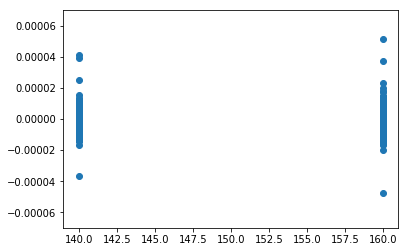

In [11]:
labels = filtered_epoch.events[:,-1]

plt.ylim(-7.0e-05, 7.0e-05)
plt.scatter(labels, reshaped[:,1000])

In [12]:
(reshaped[1,:])

array([2.29729041e-05, 1.79218559e-05, 1.65427913e-05, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [15]:

train_x, test_x, train_y, test_y = train_test_split(filtered_epoch._data, labels, train_size = 0.7)
print("train_x size :: ", train_x.shape)
print("train_y size :: ", train_y.shape)
 
print("test_x size :: ", test_x.shape)
print("test_y size :: ", test_y.shape)

/Users/shateeshbhugwansing/anaconda/envs/mne/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


train_x size ::  (896, 129, 180)
train_y size ::  (896,)
test_x size ::  (384, 129, 180)
test_y size ::  (384,)


In [16]:
train_x = vectorizer.fit_transform(train_x)
test_x = vectorizer.fit_transform(test_x)

In [17]:
reg_model = LogisticRegression()
reg_model.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
train_accuracy = reg_model.score(train_x, train_y)
# train_accuracy

test_accuracy = reg_model.score(test_x, test_y)
# test_accuracy
train_accuracy

1.0

### Attempt to classify with another target set, to confirm that my pipeline is okay. 

In [19]:
epoch.event_id

{'trail_start': 31,
 'left_button': 131,
 'right_button': 132,
 'congruent': 133,
 'incongruent': 134,
 'correct': 129,
 'incorrect': 130,
 't_baby': 135,
 't_bell': 136,
 't_bird': 137,
 't_burp': 138,
 't_dog': 139,
 't_drum': 140,
 't_knock': 141,
 't_laugh': 142,
 't_phone': 143,
 't_train': 144,
 't_water': 145,
 'f_baby': 155,
 'f_bell': 156,
 'f_bird': 157,
 'f_burp': 158,
 'f_dog': 159,
 'f_drum': 160,
 'f_knock': 161,
 'f_laugh': 162,
 'f_phone': 163,
 'f_train': 164,
 'f_water': 165,
 'flanker_stim_1': 1,
 'flanker_stim_2': 2,
 'flanker_stim_3': 3,
 'flanker_stim_4': 4,
 'flanker_stim_5': 5,
 'flanker_stim_6': 6,
 'flanker_stim_7': 7,
 'flanker_stim_8': 8,
 'flanker_stim_9': 9,
 'flanker_stim_10': 10,
 'flanker_stim_11': 11,
 'flanker_stim_12': 12,
 'target_stim_13': 13,
 'target_stim_14': 14,
 'target_stim_15': 15,
 'target_stim_16': 16,
 'target_stim_17': 17,
 'target_stim_18': 18,
 'target_stim_19': 19,
 'target_stim_20': 20,
 'target_stim_21': 21,
 'target_stim_22': 22,
 

In [20]:
congruency = epoch[(epoch.events[:,-1] == 133) | (epoch.events[:,-1] == 134)]

In [21]:
congruency._data.shape

(640, 129, 180)

In [22]:
congruency_data = vectorizer.fit_transform(congruency._data)



In [23]:
congruency_labels = congruency.events[:,-1]
train_x, test_x, train_y, test_y = train_test_split(congruency_data, congruency_labels, train_size = 0.7)


/Users/shateeshbhugwansing/anaconda/envs/mne/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [24]:
print("train_x size :: ", train_x.shape)
print("train_y size :: ", train_y.shape)
 
print("test_x size :: ", test_x.shape)
print("test_y size :: ", test_y.shape)

train_x size ::  (448, 23220)
train_y size ::  (448,)
test_x size ::  (192, 23220)
test_y size ::  (192,)


In [29]:
reg_model = LogisticRegression()
reg_model.fit(train_x, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
train_accuracy = reg_model.score(train_x, train_y)
print("train accuracy: ", train_accuracy)

test_accuracy = reg_model.score(test_x, test_y)
print("test accuracy", test_accuracy)

train accuracy:  0.9174107142857143
test accuracy 0.90625


## Re-do experiments 1, with new classification problem: congruent vs. incongruent

In [31]:
congruency = epoch[(epoch.events[:,-1] == 133) | (epoch.events[:,-1] == 134)]
congruency_data = vectorizer.fit_transform(congruency._data)
congruency_labels = congruency.events[:,-1]

In [32]:
# clf = make_pipeline(
#                     Vectorizer(),
#                     MinMaxScaler(),
#                     LogisticRegression(penalty='l2'))

# I already vectorized the data in prev. cell. Let's just use Logistic regression

cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
clf = LogisticRegression()

preds = np.empty(len(congruency._data))
for train, test in cv.split(congruency_data, congruency_labels):
    clf.fit(congruency_data[train], congruency_labels[train])
    preds[test] = clf.predict(congruency_data[test])
#     print(clf.score(congruency_data[test], congruency_labels[test]))
    
target_names = [ '133', '134']
report = classification_report(congruency_labels, preds, target_names=target_names)
print(report)

             precision    recall  f1-score   support

        133       0.84      0.98      0.90       320
        134       0.97      0.82      0.89       320

avg / total       0.91      0.90      0.90       640



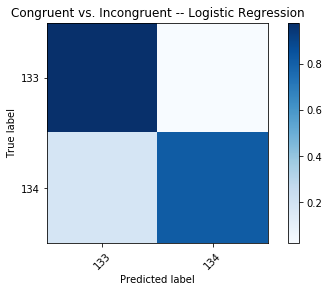

In [33]:
# Normalized confusion matrix
from sklearn.metrics import confusion_matrix
from mne.viz import tight_layout

target_names = [ '133', '134']


cm = confusion_matrix(congruency_labels, preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Congruent vs. Incongruent -- Logistic Regression')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Re-do experiment 2 -- Congruent vs. Incongruent, SVM

In [38]:
from sklearn.svm import SVC  # noqa
from sklearn.model_selection import ShuffleSplit  # noqa

cv2 = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
svc = SVC(C=1, kernel='linear')


clf2 = make_pipeline(
                    Vectorizer(),
                    MinMaxScaler(),
                    svc)


labels2 = congruency.events[:,-1]
preds2 = np.empty(len(congruency._data))
for train2, test2 in cv2.split(congruency._data, labels2):
    clf2.fit(congruency_data[train2], labels2[train2])
    preds2[test2] = clf.predict(congruency_data[test2])
    
target_names2 = [ '133', '134']
report2 = classification_report(labels2, preds2, target_names=target_names2)
print(report2)

             precision    recall  f1-score   support

        133       0.86      0.99      0.92       320
        134       0.99      0.84      0.91       320

avg / total       0.92      0.91      0.91       640



In [ ]:
cm2 = confusion_matrix(congruency_labels, preds2)
cm2_normalized = cm2.astype(float) / cm2.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.imshow(cm2_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Congruent vs. Incongruent -- SVM')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
len(preds2)